## Tweet project Part 3

#### 1. Correlation in influencers tweets and trends in education industry
#### 2. Geographical visualisation

In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [3]:
!pip install a-world-of-countries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00


In [4]:
import os
import time
import subprocess
from matplotlib import pyplot as plt
import datetime
import pandas as pd

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import awoc
my_world = awoc.AWOC()

In [5]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [6]:
## Read processed data
bucket_name = 'prayutjain-tweet-bucket'
prefix = 'processed_data'

df = spark.read.parquet('gs://' + bucket_name + '/' + prefix + '/')

22/12/08 02:50:26 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## 1. Trends in education industry and were the influencers tweeting at that time?

In [19]:
df_trend = df\
.withColumn('tweet_created_at',to_date('tweet_created_at'))\
.groupBy('tweet_created_at')\
.agg(count('*').alias('total_tweets'))

df_trend1 = df_trend\
.toPandas()

influencers = ['19616718','19675956','78874095','1276140426','113388430']
influencers1='|'.join(["(" + c +")" for c in influencers])

df_inf = df\
.withColumn('tweet_created_at',to_date('tweet_created_at'))\
.where(col('user_id_str').rlike(influencers1))\
.groupBy('tweet_created_at')\
.agg(count('*').alias('total_tweets'))\
.toPandas()

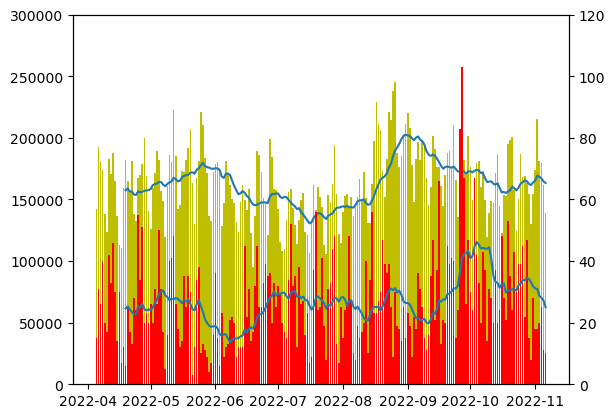

In [57]:
df_trend1 = df_trend1.sort_values('tweet_created_at')
df_trend1['MA'] = df_trend1['total_tweets'].rolling(window=15).mean()
plt.ylim(0, 300000)
plt.bar(df_trend1['tweet_created_at'], df_trend1['total_tweets'],color='y')
plt.plot(df_trend1['tweet_created_at'], df_trend1['MA'])

df_inf = df_inf.sort_values('tweet_created_at')
df_inf['MA'] = df_inf['total_tweets'].rolling(window=15).mean()
axes2 = plt.twinx()
axes2.bar(df_inf['tweet_created_at'], df_inf['total_tweets'], color='r')
axes2.plot(df_inf['tweet_created_at'], df_inf['MA'])
axes2.set_ylim(0, 120)



plt.show()

In [100]:
## Correlation

df_comb = df_trend1.join(df_inf,lsuffix='_all', rsuffix='_influencers')

df_comb.corr(method='pearson')

,total_tweets_all,MA_all,total_tweets_influencers,MA_influencers
total_tweets_all,1.000000,0.555187,-0.012362,0.080499
MA_all,0.555187,1.000000,-0.118437,0.016482
total_tweets_influencers,-0.012362,-0.118437,1.000000,0.381971
MA_influencers,0.080499,0.016482,0.381971,1.000000


#### No correlation between influencers and tweet frequency

### 1.2 Monthly tweet count

In [60]:
df_trend1['month'] = pd.to_datetime(df_trend1['tweet_created_at'], errors='coerce').dt.to_period('M')
df_trend1.head()

,tweet_created_at,total_tweets,month
0,2022-08-02,153195,2022-08
1,2022-08-20,173042,2022-08
2,2022-05-01,125994,2022-05
3,2022-09-07,182315,2022-09
4,2022-07-27,162715,2022-07


<AxesSubplot:xlabel='month'>

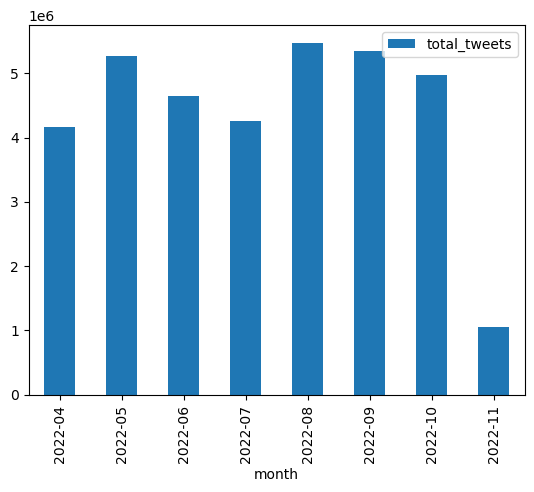

In [66]:
df_trend_mth = df_trend1.groupby('month').agg({'total_tweets':'sum'})

df_trend_mth.plot(kind='bar')

In [65]:
df_trend_mth.head()

,total_tweets
month,
2022-04,4159735
2022-05,5273797
2022-06,4653881
2022-07,4259473
2022-08,5477476


## Do a word count in may and August 

#### My guess is May has high tweets because of Uvalde - so safety of kids

#### In August, it must be either the debt release

## Also create region wise timeline of tweets and then see the trends

## 2. Geographical distribution

In [102]:
df.select('user_location').distinct().show(truncate=False)

+--------------------+
|       user_location|
+--------------------+
|      washington, dc|
|   St Petersburg, FL|
|           Bangalore|
|     Gainesville, FL|
|            England |
|      Luton, England|
|              Heaven|
|now to ..central ...|
|       Jonesboro, AR|
|           Worcester|
|Port Elizabeth So...|
|  South East England|
|     Toledo, OH  USA|
|    Mid-Atlantic USA|
|CyberSpace :-) #b...|
|getting a fucking...|
|        Inside Life |
|USA, Earth, Milky...|
| Brownsburg, Indiana|
|                Utah|
+--------------------+
only showing top 20 rows



In [7]:
df_loc = df.select('user_id_str','user_location').distinct()\
.groupBy('user_location')\
.agg(count('*').alias('total_twitterers'))

df_loc.orderBy('total_twitterers',ascending=False).show()

+---------------+----------------+
|  user_location|total_twitterers|
+---------------+----------------+
|           null|         3717099|
|  United States|           73990|
| Lagos, Nigeria|           44715|
|        Nigeria|           36650|
|Los Angeles, CA|           35669|
|          India|           34314|
|        she/her|           32777|
|London, England|           31382|
|California, USA|           28130|
|    Chicago, IL|           27540|
|    Houston, TX|           27131|
|    Atlanta, GA|           24064|
|     Texas, USA|           23623|
|            USA|           22193|
|         Canada|           21407|
| Nairobi, Kenya|           21309|
| United Kingdom|           21308|
|   Florida, USA|           21198|
| Washington, DC|           20427|
|   New York, NY|           19718|
+---------------+----------------+
only showing top 20 rows



22/12/08 02:52:33 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670438604801_0006_01_000007 on host: hub-msca-bdp-dphub-students-backup-prayutjain-sw-jj5k.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-08 02:52:33.588]Container killed on request. Exit code is 143
[2022-12-08 02:52:33.589]Container exited with a non-zero exit code 143. 
[2022-12-08 02:52:33.593]Killed by external signal
.
22/12/08 02:52:33 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 6 for reason Container from a bad node: container_1670438604801_0006_01_000007 on host: hub-msca-bdp-dphub-students-backup-prayutjain-sw-jj5k.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-08 02:52:33.588]Container killed on request. Exit code is 143
[2022-12-08 02:52:33.589]Container exited with a non-zero exit code 143. 
[2022-12-08 02:52:33.593]Killed by external signal
.
22/12

In [15]:
## Clean location data
na_ctry = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY','Texas','USA','US','United States',
            'Canada','canada','Toronto','toronto','Ontario','ontario',"Alaska", "Alabama",
             "Arkansas", "American Samoa", "Arizona", "California", "Colorado",
             "Connecticut", "District ", "of Columbia", "Delaware", "Florida", 
             "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana",
             "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", 
             "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina",
             "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", 
             "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", 
             "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", 
             "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming",
             "Aberdeen", "Abilene", "Akron", "Albany", "Albuquerque", "Alexandria", "Allentown",
             "Amarillo", "Anaheim", "Anchorage", "Ann Arbor", "Antioch", "Apple Valley", "Appleton",
             "Arlington", "Arvada", "Asheville", "Athens", "Atlanta", "Atlantic City", "Augusta", 
             "Aurora", "Austin", "Bakersfield", "Baltimore", "Barnstable", "Baton Rouge", "Beaumont",
             "Bel Air", "Bellevue", "Berkeley", "Bethlehem", "Billings", "Birmingham", "Bloomington", 
             "Boise", "Boise City", "Bonita Springs", "Boston", "Boulder", "Bradenton", "Bremerton",
             "Bridgeport", "Brighton", "Brownsville", "Bryan", "Buffalo", "Burbank", "Burlington",
             "Cambridge", "Canton", "Cape Coral", "Carrollton", "Cary", "Cathedral City", "Cedar Rapids", 
             "Champaign", "Chandler", "Charleston", "Charlotte", "Chattanooga", "Chesapeake", "Chicago",
             "Chula Vista", "Cincinnati", "Clarke County", "Clarksville", "Clearwater", "Cleveland", 
             "College Station", "Colorado Springs", "Columbia", "Columbus", "Concord", "Coral Springs", 
             "Corona", "Corpus Christi", "Costa Mesa", "Dallas", "Daly City", "Danbury", "Davenport", 
             "Davidson County", "Dayton", "Daytona Beach", "Deltona", "Denton", "Denver", "Des Moines",
             "Detroit", "Downey", "Duluth", "Durham", "El Monte", "El Paso", "Elizabeth", "Elk Grove",
             "Elkhart", "Erie", "Escondido", "Eugene", "Evansville", "Fairfield", "Fargo", "Fayetteville",
             "Fitchburg", "Flint", "Fontana", "Fort Collins", "Fort Lauderdale", "Fort Smith",
             "Fort Walton Beach", "Fort Wayne", "Fort Worth", "Frederick", "Fremont", "Fresno", 
             "Fullerton", "Gainesville", "Garden Grove", "Garland", "Gastonia", "Gilbert", "Glendale",
             "Grand Prairie", "Grand Rapids", "Grayslake", "Green Bay", "GreenBay", "Greensboro",
             "Greenville", "Gulfport-Biloxi", "Hagerstown", "Hampton", "Harlingen", "Harrisburg", 
             "Hartford", "Havre de Grace", "Hayward", "Hemet", "Henderson", "Hesperia", "Hialeah",
             "Hickory", "High Point", "Hollywood", "Honolulu", "Houma", "Houston", "Howell", "Huntington", 
             "Huntington Beach", "Huntsville", "Independence", "Indianapolis", "Inglewood", "Irvine", 
             "Irving", "Jackson", "Jacksonville", "Jefferson", "Jersey City", "Johnson City", "Joliet", 
             "Kailua", "Kalamazoo", "Kaneohe", "Kansas City", "Kennewick", "Kenosha", "Killeen", "Kissimmee", 
             "Knoxville", "Lacey", "Lafayette", "Lake Charles", "Lakeland", "Lakewood", "Lancaster", "Lansing",
             "Laredo", "Las Cruces", "Las Vegas", "Layton", "Leominster", "Lewisville", "Lexington", "Lincoln",
             "Little Rock", "Long Beach", "Lorain", "Los Angeles", "Louisville", "Lowell", "Lubbock", "Macon",
             "Madison", "Manchester", "Marina", "Marysville", "McAllen", "McHenry", "Medford", "Melbourne", 
             "Memphis", "Merced", "Mesa", "Mesquite", "Miami", "Milwaukee", "Minneapolis", "Miramar",
             "Mission Viejo", "Mobile", "Modesto", "Monroe", "Monterey", "Montgomery", "Moreno Valley", 
             "Murfreesboro", "Murrieta", "Muskegon", "Myrtle Beach", "Naperville", "Naples", "Nashua", 
             "Nashville", "New Bedford", "New Haven", "New London", "New Orleans", "New York", "New York City",
             "Newark", "Newburgh", "Newport News", "Norfolk", "Normal", "Norman", "North Charleston", 
             "North Las Vegas", "North Port", "Norwalk", "Norwich", "Oakland", "Ocala", "Oceanside",
             "Odessa", "Ogden", "Oklahoma City", "Olathe", "Olympia", "Omaha", "Ontario", "Orange", 
             "Orem", "Orlando", "Overland Park", "Oxnard", "Palm Bay", "Palm Springs", "Palmdale", 
             "Panama City", "Pasadena", "Paterson", "Pembroke Pines", "Pensacola", "Peoria", "Philadelphia", 
             "Phoenix", "Pittsburgh", "Plano", "Pomona", "Pompano Beach", "Port Arthur", "Port Orange", 
             "Port Saint Lucie", "Port St. Lucie", "Portland", "Portsmouth", "Poughkeepsie", "Providence", 
             "Provo", "Pueblo", "Punta Gorda", "Racine", "Raleigh", "Rancho Cucamonga", "Reading", "Redding",
             "Reno", "Richland", "Richmond", "Richmond County", "Riverside", "Roanoke", "Rochester", "Rockford",
             "Roseville", "Round Lake Beach", "Sacramento", "Saginaw", "Saint Louis", "Saint Paul", 
             "Saint Petersburg", "Salem", "Salinas", "Salt Lake City", "San Antonio", "San Bernardino", 
             "San Buenaventura", "San Diego", "San Francisco", "San Jose", "Santa Ana", "Santa Barbara",
             "Santa Clara", "Santa Clarita", "Santa Cruz", "Santa Maria", "Santa Rosa", "Sarasota", 
             "Savannah", "Scottsdale", "Scranton", "Seaside", "Seattle", "Sebastian", "Shreveport", 
             "Simi Valley", "Sioux City", "Sioux Falls", "South Bend", "South Lyon", "Spartanburg", 
             "Spokane", "Springdale", "Springfield", "St. Louis", "St. Paul", "St. Petersburg", "Stamford", 
             "Sterling Heights", "Stockton", "Sunnyvale", "Syracuse", "Tacoma", "Tallahassee", "Tampa",
             "Temecula", "Tempe", "Thornton", "Thousand Oaks", "Toledo", "Topeka", "Torrance", "Trenton",
             "Tucson", "Tulsa", "Tuscaloosa", "Tyler", "Utica", "Vallejo", "Vancouver", "Vero Beach", 
             "Victorville", "Virginia Beach", "Visalia", "Waco", "Warren", "Washington", "Waterbury", 
             "Waterloo", "West Covina", "West Valley City", "Westminster", "Wichita", "Wilmington", 
             "Winston", "Winter Haven", "Worcester", "Yakima", "Yonkers", "York", "Youngstown"]

na_ctry1='|'.join(["(" + c +")" for c in na_ctry])

af_ctry = my_world.get_countries_list_of('Africa')
af_ctry1='|'.join(["(" + c +")" for c in af_ctry])

eu_ctry0 = my_world.get_countries_list_of('Europe')
eu_ctry1 = [*eu_ctry0,*['London','England','UK','United Kingdom','Scotland']]
eu_ctry2='|'.join(["(" + c +")" for c in eu_ctry1])

oc_ctry = my_world.get_countries_list_of('Oceania')
oc_ctry1='|'.join(["(" + c +")" for c in oc_ctry])

sa_ctry = my_world.get_countries_list_of('South America')
sa_ctry1='|'.join(["(" + c +")" for c in sa_ctry])

as_ctry = my_world.get_countries_list_of('Asia')
as_ctry1='|'.join(["(" + c +")" for c in as_ctry])

df_loc1 = df_loc\
.withColumn('Region',when(df_loc['user_location'].rlike(na_ctry1), 'North America')\
            .when(df_loc['user_location'].rlike(af_ctry1), 'Africa')\
            .when(df_loc['user_location'].rlike(sa_ctry1), 'South America')\
            .when(df_loc['user_location'].rlike(oc_ctry1), 'Oceania')\
            .when(df_loc['user_location'].rlike(eu_ctry2), 'Europe')\
            .when(df_loc['user_location'].rlike(as_ctry1), 'Asia')\
            .otherwise(df_loc['user_location']))



In [16]:
cont = ['Africa','North America','South America','Asia','Europe','Oceania']
cont1='|'.join(["(" + c +")" for c in cont])

df_loc2 = df_loc1.groupBy('Region').agg(sum('total_twitterers').alias('total_twitterers'))\
.orderBy('total_twitterers',ascending=False)\
.na.drop(subset=['Region'])\
.filter(df_loc1['Region'].rlike(cont1)).toPandas()

In [72]:
df_loc2.head(6)

,Region,total_twitterers
0,North America,2256809
1,Africa,353724
2,Asia,341445
3,Europe,182300
4,Oceania,37943
5,South America,30173


<AxesSubplot:title={'center':'Distribution of twittererss across the globe'}, xlabel='Region'>

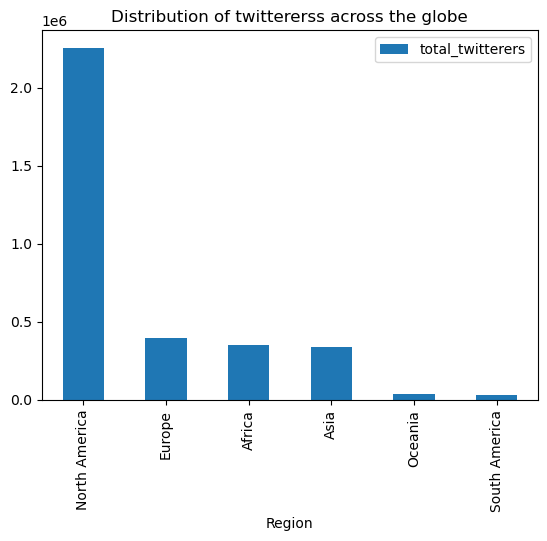

In [18]:
df_loc2.head(6).plot(kind='bar',x='Region', title = 'Distribution of twittererss across the globe')